In [1]:
import numpy as np
import chainer
from chainer import cuda, Function, gradient_check, report, training, utils, Variable
from chainer import datasets, iterators, optimizers, serializers
from chainer import Link, Chain, ChainList
import chainer.functions as F
import chainer.links as L
from chainer.training import extensions
from chainer.dataset import concat_examples
from chainer.cuda import to_cpu
from chainer import serializers
import matplotlib.pyplot as plt

In [2]:
class MLP(Chain):
    def __init__(self, n_units, n_out):
        super(MLP, self).__init__()
        with self.init_scope():
            # the size of the inputs to each layer will be inferred
            self.l1 = L.Linear(None, n_units)  # n_in -> n_units
            self.l2 = L.Linear(None, n_units)  # n_units -> n_units
            self.l3 = L.Linear(None, n_out)    # n_units -> n_out

    def __call__(self, x):
        h1 = F.relu(self.l1(x))
        h2 = F.relu(self.l2(h1))
        y = self.l3(h2)
        return y

In [3]:
model = MLP(n_units=10, n_out=10)  # the input size, 784, is inferred
optimizer = optimizers.SGD()
optimizer.setup(model)

In [4]:
max_epoch = 20
batchsize = 32

train, test = datasets.get_mnist()
train_iter = iterators.SerialIterator(train, batchsize)
test_iter = iterators.SerialIterator(test, batchsize, repeat=False, shuffle=False)

In [5]:
while train_iter.epoch < max_epoch:

    # ---------- One iteration of the training loop ----------
    train_batch = train_iter.next()
    image_train, target_train = concat_examples(train_batch)

    # Calculate the prediction of the network
    prediction_train = model(image_train)

    # Calculate the loss with softmax_cross_entropy
    loss = F.softmax_cross_entropy(prediction_train, target_train)

    # Calculate the gradients in the network
    model.cleargrads()
    loss.backward()

    # Update all the trainable paremters
    optimizer.update()
    # --------------------- until here ---------------------

    # Check the validation accuracy of prediction after every epoch
    if train_iter.is_new_epoch:  # If this iteration is the final iteration of the current epoch

        # Display the training loss
        print('epoch:{:02d} train_loss:{:.04f} '.format(
            train_iter.epoch, float(loss.data)), end='')

        test_losses = []
        test_accuracies = []
        while True:
            test_batch = test_iter.next()
            image_test, target_test = concat_examples(test_batch)

            # Forward the test data
            prediction_test = model(image_test)

            # Calculate the loss
            loss_test = F.softmax_cross_entropy(prediction_test, target_test)
            test_losses.append(to_cpu(loss_test.data))

            # Calculate the accuracy
            accuracy = F.accuracy(prediction_test, target_test)
            accuracy.to_cpu()
            test_accuracies.append(accuracy.data)

            if test_iter.is_new_epoch:
                test_iter.epoch = 0
                test_iter.current_position = 0
                test_iter.is_new_epoch = False
                test_iter._pushed_position = None
                break

        print('val_loss:{:.04f} val_accuracy:{:.04f}'.format(
            np.mean(test_losses), np.mean(test_accuracies)))

epoch:01 train_loss:0.6152 val_loss:0.6352 val_accuracy:0.8061
epoch:02 train_loss:0.4941 val_loss:0.4652 val_accuracy:0.8624
epoch:03 train_loss:0.5614 val_loss:0.3896 val_accuracy:0.8874
epoch:04 train_loss:0.3303 val_loss:0.3480 val_accuracy:0.9005
epoch:05 train_loss:0.1152 val_loss:0.3246 val_accuracy:0.9050
epoch:06 train_loss:0.2704 val_loss:0.3159 val_accuracy:0.9088
epoch:07 train_loss:0.2071 val_loss:0.2992 val_accuracy:0.9136
epoch:08 train_loss:0.1955 val_loss:0.2862 val_accuracy:0.9161
epoch:09 train_loss:0.2916 val_loss:0.2908 val_accuracy:0.9138
epoch:10 train_loss:0.1777 val_loss:0.2783 val_accuracy:0.9205
epoch:11 train_loss:0.4051 val_loss:0.2713 val_accuracy:0.9223
epoch:12 train_loss:0.0581 val_loss:0.2651 val_accuracy:0.9219
epoch:13 train_loss:0.2233 val_loss:0.2613 val_accuracy:0.9234
epoch:14 train_loss:0.1178 val_loss:0.2599 val_accuracy:0.9255
epoch:15 train_loss:0.0955 val_loss:0.2617 val_accuracy:0.9248
epoch:16 train_loss:0.1569 val_loss:0.2517 val_accuracy

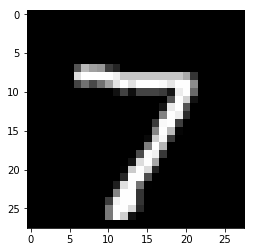

label: 7
predicted label: 7


In [18]:
x, t = test[0]
plt.imshow(x.reshape(28, 28), cmap='gray')
plt.show()
print('label:', t)
x = x[None, ...]

# forward calculation of the model by sending X
y = model(x)

# The result is given as Variable, then we can take a look at the contents by the attribute, .data.
y = y.data

# Look up the most probable digit number using argmax
pred_label = y.argmax(axis=1)

print('predicted label:', pred_label[0])